In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def catboost_metric(model_cb, X_test, y_test ):
    y_pred_cb = model_cb.predict(X_test)
    y_pred_cb_proba = model_cb.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_cb_proba)
    accuracy = accuracy_score(y_test, y_pred_cb)
    precision = precision_score(y_test, y_pred_cb)
    recall = recall_score(y_test, y_pred_cb)
    f1 = f1_score(y_test, y_pred_cb)

    metrics_cb = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics_cb, y_pred_cb, y_pred_cb_proba

def lightgbm_metric( model, X_test, y_test):

    y_pred_lgb = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_lgb)   
    best_threshold = thresholds[(tpr - fpr).argmax()]
    print(best_threshold)

    roc_auc = roc_auc_score(y_test, y_pred_lgb)
    print(f'ROC AUC: {roc_auc:.4f}')
    y_pred = (y_pred_lgb >= best_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    metrics = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        }
    return metrics, y_pred, y_pred_lgb

def plot_confusion_matrix(y_test, y_pred, title='Model'):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False)
    plt.title(f'Confusion Matrix - {title}', fontsize=16, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    return plt


import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем DataFrame деревьев
# tree_df = booster.trees_to_dataframe()

def visualize_tree_splits(tree_df, title):
    feature_counts = tree_df['split_feature'].value_counts()
    main_feature = feature_counts.index[0]
    main_feature_splits = tree_df.loc[tree_df['split_feature'] == main_feature, 'threshold']

    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    fig.suptitle(f"{title}", fontsize=16, fontweight='bold')
    sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    axes[0].set_title('Частота использования признаков в split-ах')
    axes[0].set_ylabel('Число split-ов')
    axes[0].set_xlabel('Признак')

    sns.histplot(main_feature_splits, bins=20, color='orange', ax=axes[1])
    axes[1].set_title(f'Пороги split для признака {main_feature}')
    axes[1].set_xlabel('Порог split')
    axes[1].set_ylabel('Частота')
    
    gain_means = tree_df.groupby('split_feature')['split_gain'].mean().sort_values(ascending=False).head(15)
    sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')
    axes[2].set_title('Средний прирост (gain) по признакам')
    axes[2].set_xlabel('Средний split_gain')
    axes[2].set_ylabel('Признак')

    plt.tight_layout()
    plt.show()

# Загрузка данных

In [3]:
train = pd.read_csv('train.csv')
train.create_time = pd.to_datetime(train.create_time)
train.model_create_time = pd.to_datetime(train.model_create_time)

test = pd.read_csv('test.csv')
test.create_time = pd.to_datetime(test.create_time)
test.model_create_time = pd.to_datetime(test.model_create_time)

web = pd.read_csv('t1_webstat.csv')
web.sort_values('date_time', inplace=True)
web.date_time = pd.to_datetime(web.date_time)

In [4]:
display(web, train)

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2267023,134622417,1976-02-16 22:55:29.327,3,120,26.0,NaN,NaN,NaN,NaN,NaN
2267024,134622417,1976-02-16 22:55:55.497,1,121,17.0,4271.0,31165696.0,NaN,NaN,NaN
2078414,134622417,1976-02-16 22:56:12.727,2,122,159.0,4271.0,NaN,NaN,NaN,NaN
2000326,134622417,1976-02-16 22:58:51.717,7,123,51.0,NaN,NaN,NaN,NaN,NaN


,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,5,8.0,123777004,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
1,1270034,1975-12-26 10:28:57,9896348,753,1,2.0,123781654,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
2,1268272,1975-12-25 11:24:28,9896348,753,2,3.0,123591002,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
3,1270544,1975-12-26 14:16:06,9896348,753,1,1.0,123832302,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
4,1270970,1975-12-26 18:21:47,9896348,753,3,56.0,123881603,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104590,1250981,1975-12-16 12:11:32,68657110,1497,4,1.0,121795335,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104591,1173775,1975-11-08 11:29:50,60391507,1354,1,2.0,114277105,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1
104592,1180920,1975-11-12 09:14:35,66971400,1452,2,NaN,114972131,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,0
104593,1177882,1975-11-10 17:28:07,60391498,1433,4,2.0,114672813,2873,1229,1183,35231362,1,4.0,3.0,1183,12,1,1976-01-23 00:08:20,1


In [5]:
web['date_time'].info()

<class 'pandas.core.series.Series'>
Index: 3334243 entries, 2268917 to 2059781
Series name: date_time
Non-Null Count    Dtype         
--------------    -----         
3334243 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 50.9 MB


In [25]:
session_agg = web.groupby('sessionkey_id', sort=False).agg(
    product_sale_count=('product_in_sale', 'sum'),
    total_sec_dt=('date_time', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds()),
    total_sec_dur=('pageview_duration_sec', 'sum'),
    unique_pages_count=('pageview_number', 'nunique'),
    mean_sec_dur=('pageview_duration_sec', 'mean'),
    max_sec_dur=('pageview_duration_sec', 'max'),
    min_sec_dur=('pageview_duration_sec', 'min'),
    total_receipt=('price', 'sum'),
    weekday_first_visit=('date_time', lambda x: x.iloc[0].weekday()),
    day_period_type=('date_time', lambda x: 0 if 5 <= x.iloc[0].hour < 12 else
                                            1 if 12 <= x.iloc[0].hour < 18 else
                                            2 if 18 <= x.iloc[0].hour < 23 else
                                            3 if 0 <= x.iloc[0].hour < 5 else -1)
)

session_agg['sec_diff'] = session_agg['total_sec_dt'] - session_agg['total_sec_dur']
session_agg['density_sale'] = session_agg['product_sale_count'] / session_agg['unique_pages_count']
session_agg['sec_dur_diff'] = session_agg['max_sec_dur'] - session_agg['min_sec_dur']

session_agg.drop(['max_sec_dur', 'unique_pages_count', 'min_sec_dur', 'total_sec_dt', 'total_sec_dur'], axis=1, inplace=True)

session_agg

,product_sale_count,mean_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff,density_sale,sec_dur_diff
sessionkey_id,,,,,,,,
109996122,0.0,15.000000,0.0,4,1,-0.320,0.000000,16.0
110019268,1.0,82.500000,2986.0,4,1,0.560,0.333333,79.0
110020180,1.0,NaN,4490.0,4,1,0.000,1.000000,NaN
110040418,4.0,54.500000,2312.0,4,1,46.490,0.363636,265.0
110044482,1.0,NaN,4490.0,4,1,0.000,1.000000,NaN
...,...,...,...,...,...,...,...,...
134626779,0.0,22.000000,0.0,0,2,-22.000,0.000000,0.0
134627402,1.0,40.666667,411.0,0,2,54.784,0.142857,108.0
134628420,0.0,23.250000,0.0,0,2,180.624,0.000000,41.0


In [ ]:
X_tr = train.merge(session_agg, how='left', on='sessionkey_id', sort=False)
X_tr.sort_values('create_time', inplace=True)

cat_features = X_tr.select_dtypes(include='object').columns.tolist()


X_tr[cat_features] = X_tr[cat_features].fillna("missing")
X_tr = X_tr.fillna(0)

# X = X_tr.drop(columns=['is_callcenter'])
# y = X_tr['is_callcenter']

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, 
#                                                       random_state=42, shuffle=False)

# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
#                                                   random_state=42, shuffle=False)

train_df, temp = train_test_split(X_tr, test_size=0.3, 
                                    random_state=42, shuffle=False)

val_df, test_df = train_test_split(temp, test_size=0.5,
                                                  random_state=42, shuffle=False)

In [27]:
X_tr[session_agg.columns].describe()

,product_sale_count,mean_sec_dur,total_receipt,weekday_first_visit,day_period_type,sec_diff,density_sale,sec_dur_diff
count,104595.000000,104595.000000,1.045950e+05,104595.000000,104595.000000,104595.000000,104595.000000,104595.000000
mean,5.095492,108.384084,9.211111e+03,2.488341,0.893274,190.365099,0.428692,401.089077
std,7.433088,187.292284,2.590043e+04,1.892720,0.721486,1169.971900,0.274643,704.312613
min,0.000000,-7618.545455,0.000000e+00,0.000000,-1.000000,-31455.620000,0.000000,0.000000
25%,1.000000,31.666667,9.985000e+02,1.000000,0.000000,-0.074000,0.250000,49.000000
50%,3.000000,64.300000,3.230000e+03,2.000000,1.000000,0.503000,0.400000,215.000000
75%,6.000000,126.290278,8.914000e+03,4.000000,1.000000,246.423500,0.538462,591.000000
max,216.000000,31730.000000,2.750789e+06,6.000000,3.000000,185359.293000,7.428571,52819.000000


In [12]:
train_df['is_callcenter'].value_counts()

is_callcenter
0    46816
1    26400
Name: count, dtype: int64

In [13]:
X_tr['day_period_type'].value_counts()

day_period_type
 1.0    55642
 0.0    29488
 2.0    17237
 3.0     1386
-1.0      842
Name: count, dtype: int64

<Axes: xlabel='is_callcenter', ylabel='sec_diff'>

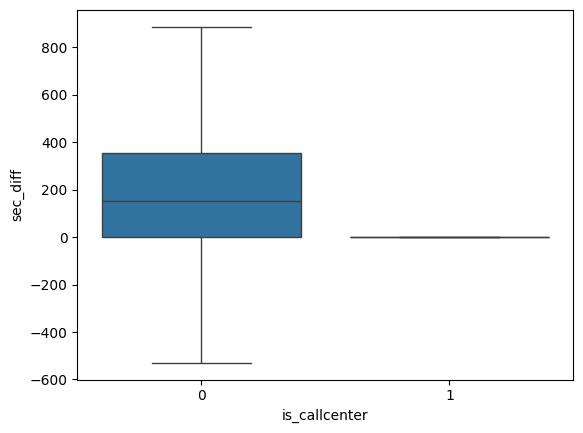

In [28]:
sns.boxplot(X_tr, y='sec_diff', x='is_callcenter', showfliers=False) # 0_0


<Axes: xlabel='is_callcenter', ylabel='density_sale'>

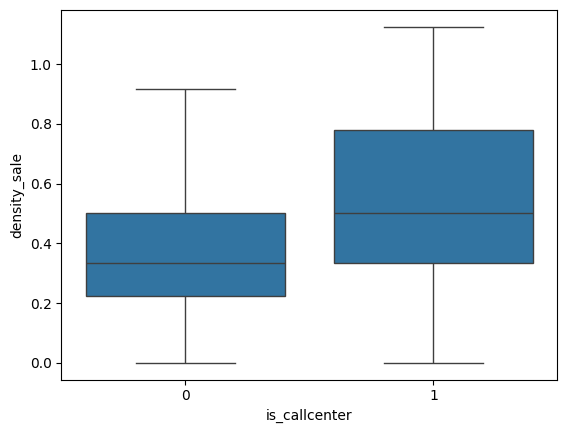

In [17]:
sns.boxplot(X_tr, y='density_sale', x='is_callcenter', showfliers=False) # 0_0


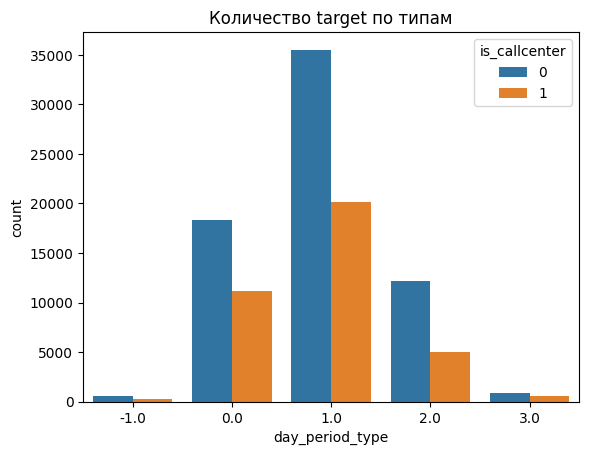

In [18]:

sns.countplot(x='day_period_type', hue='is_callcenter', data=X_tr)
plt.title('Количество target по типам')
plt.show()

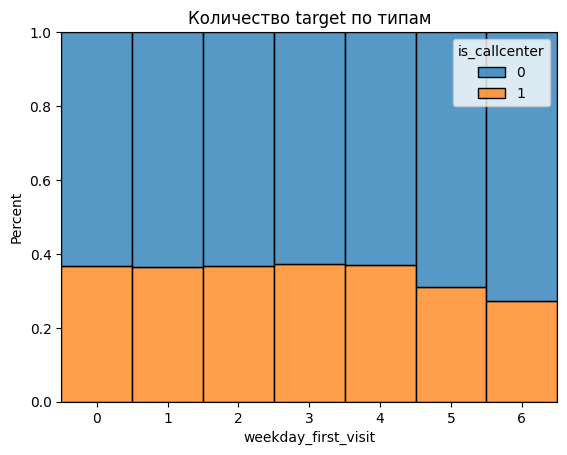

In [13]:

sns.histplot(x='weekday_first_visit', hue='is_callcenter', data=X_tr, stat='percent', discrete=True, multiple='fill')
plt.title('Количество target по типам')
plt.show()

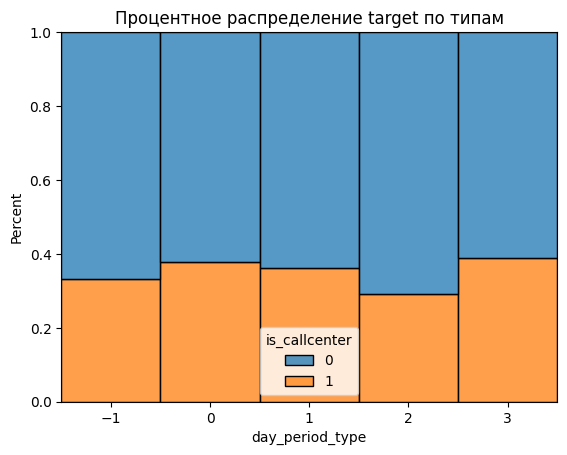

In [14]:
sns.histplot(x='day_period_type', hue='is_callcenter', data=X_tr, stat='percent', discrete=True, multiple='fill')
plt.title('Процентное распределение target по типам')
plt.show()

### Функция обучения модели catboost

In [65]:
from catboost import CatBoostClassifier, Pool
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

params = {"score_function": 'L2',
          "depth": 5,
          "eta": 0.15,
          "eval_metric": 'AUC',
          "iterations": 1000,
          "verbose": 50,
          "use_best_model":True,
          "random_seed":42,
          "early_stopping_rounds":200
          }

def catboost_train_model(train, valid, test, features, params=params):
    X_tr, y_tr = train[features], train['is_callcenter']
    X_val, y_val = valid[features], valid['is_callcenter']
    X_test, y_test = test[features], test['is_callcenter']

    cat_cols = X_tr.select_dtypes(include='object').columns.tolist()
    num_features = X_tr.select_dtypes(['float', 'int']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('catboost', CatBoostEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_features),
        ],
        remainder='drop',
        verbose_feature_names_out=False
    )

    X_tr_prepared = preprocessor.fit_transform(X_tr, y_tr)
    X_val_prepared = preprocessor.transform(X_val)
    X_test_prepared = preprocessor.transform(X_test)

    train_pool_baseline = Pool(X_tr_prepared, y_tr)
    valid_pool_baseline = Pool(X_val_prepared, y_val)

    model_cb= CatBoostClassifier(**params)

    model_cb.fit(train_pool_baseline, eval_set=valid_pool_baseline, plot=True)
    metrics_cb_baseline, y_pred_cb, y_pred_cb_proba = catboost_metric(model_cb, X_test_prepared, y_test)
    print(metrics_cb_baseline)
    plot_confusion_matrix(y_test, y_pred_cb, title='CatBoost')
    return model_cb

### Функция обучения модели Lightgbm


In [77]:
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler

params_lgbm = {
    "learning_rate": 0.1,
    "max_leaves": 40, 
    "objective": 'binary',
    "early_stopping_rounds": 200,
    "random_seed":42
}

def lightgbm_train_model(train, valid, test, features, params=params_lgbm):

    X_tr, y_tr = train[features], train['is_callcenter']
    X_val, y_val = valid[features], valid['is_callcenter']
    X_test, y_test = test[features], test['is_callcenter']

    cat_cols = X_tr.select_dtypes(include='object').columns.tolist()
    num_features = X_tr.select_dtypes(['float', 'int']).columns.tolist()

    preprocessor = ColumnTransformer([
        ('catboost', CatBoostEncoder(), cat_cols),
        ('scaler', StandardScaler(), num_features),
        ],
        remainder='drop',
        verbose_feature_names_out=False
    )

    X_tr_prepared = preprocessor.fit_transform(X_tr, y_tr)
    X_val_prepared = preprocessor.transform(X_val)
    X_test_prepared = preprocessor.transform(X_test)

    model_lgbm = lgb.LGBMClassifier(
        **params
    )
    model_lgbm.fit(X_tr_prepared, 
                    y_tr, 
                    eval_set=[(X_val_prepared, y_val)], 
                    eval_metric=['auc', 'cross_entropy'],
                    feature_name=features.tolist()
                    )
    
    metrics_lgb, y_pred_lgb_bin, y_pred_lgb_proba = lightgbm_metric(model_lgbm, X_test_prepared, y_test)
    plot_confusion_matrix(y_test, y_pred_lgb_bin, title='LightGBM with UMAP Clusters')
    print(metrics_lgb)
    return model_lgbm

In [21]:
train_df[['day_period_type', 'weekday_first_visit']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73216 entries, 87721 to 70481
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   day_period_type      73216 non-null  float64
 1   weekday_first_visit  73216 non-null  float64
dtypes: float64(2)
memory usage: 1.7 MB


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8757219	best: 0.8757219 (0)	total: 8.07ms	remaining: 4.59s
50:	test: 0.8927819	best: 0.8928260 (49)	total: 309ms	remaining: 3.15s
100:	test: 0.8931103	best: 0.8931583 (94)	total: 616ms	remaining: 2.86s
150:	test: 0.8930866	best: 0.8931583 (94)	total: 935ms	remaining: 2.59s
Stopped by overfitting detector  (80 iterations wait)

bestTest = 0.8931583353
bestIteration = 94

Shrink model to first 95 iterations.
{'Accuracy': 0.8279158699808795, 'Precision': 0.6936608031861932, 'Recall': 0.8303535955502582, 'F1-Score': 0.755877034358047, 'ROC-AUC': 0.8926670823087689}


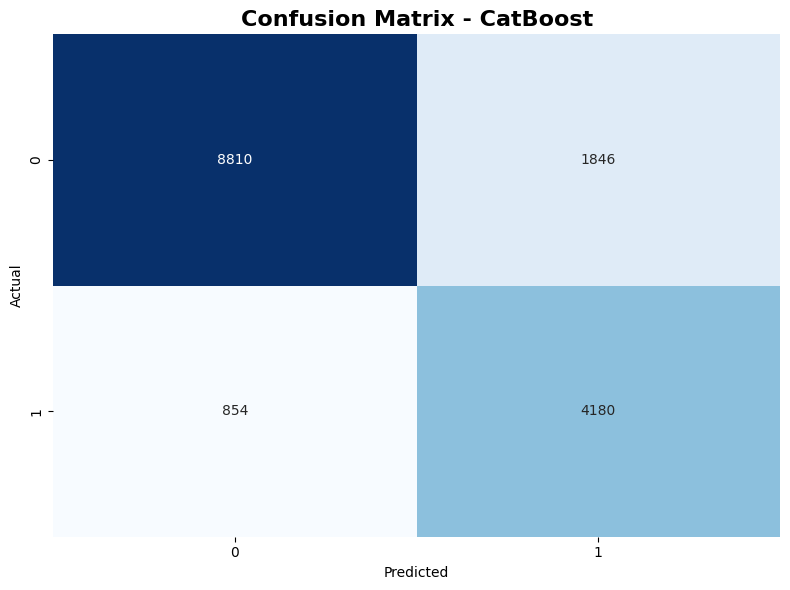

In [29]:
# params = {"score_function": 'L2',
#           "depth": 5,
#           "eta": 0.15,
#           "eval_metric": 'AUC',
#           "iterations": 500,
#           "verbose": 50}


features = session_agg.columns
model_cd = catboost_train_model(train_df, val_df, test_df, features, params)


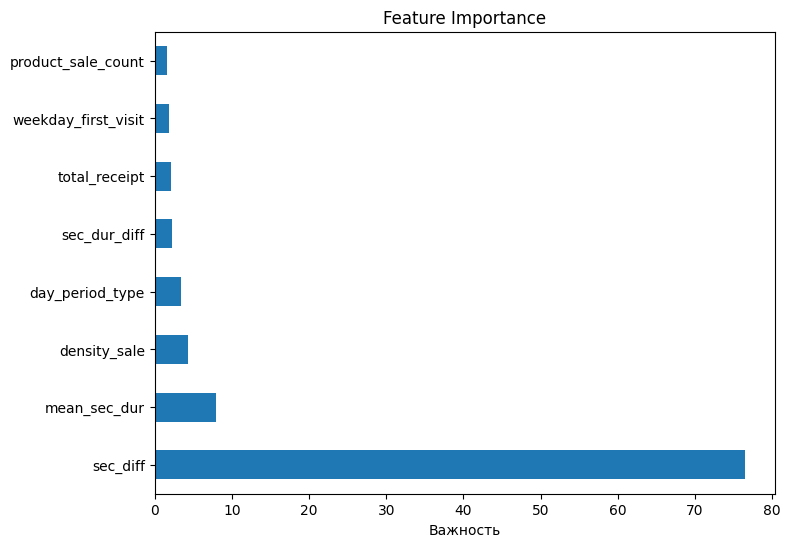

In [30]:
importances = pd.Series(model_cd.feature_importances_, index=features)
importances.nlargest(10).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_round is set=80, early_stopping_rounds=80 will be ignored. Current value: early_stopping_round=80
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 26400, number of negative: 46816
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 73216.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 73216, number of used features: 8
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current 

f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


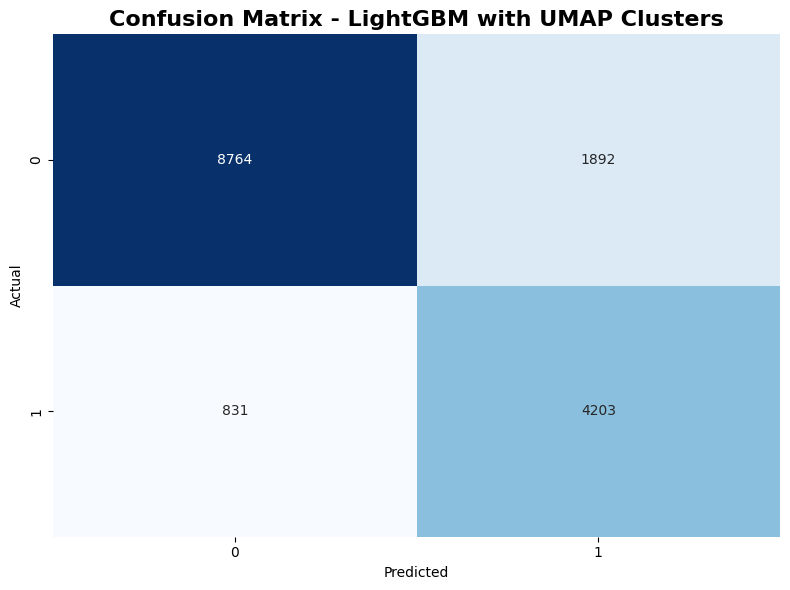

C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])


{'Accuracy': 0.8264499681325685, 'Precision': 0.6895816242821985, 'Recall': 0.83492252681764, 'F1-Score': 0.755323928475155, 'ROC-AUC': 0.8286849871325437}


C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


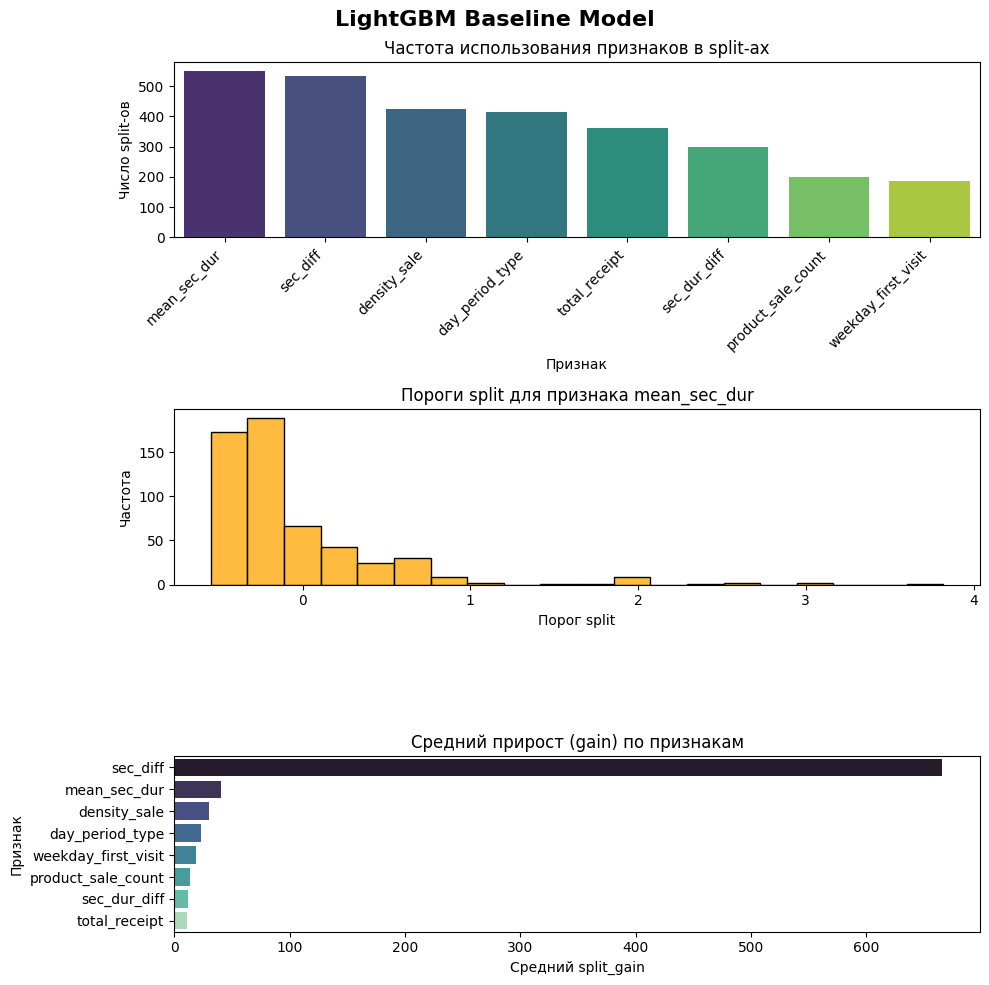

In [31]:

features = session_agg.columns
model_lgbm = lightgbm_train_model(train_df, val_df, test_df, features, params_lgbm)
tree_df = model_lgbm.booster_.trees_to_dataframe()
visualize_tree_splits(tree_df, title='LightGBM Baseline Model')

# Кластеризация

In [69]:
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold

features = session_agg.columns
X_tr, y_tr = train_df[features], train_df['is_callcenter']
X_temp, y_temp = temp[features], temp['is_callcenter']

k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(X_tr)

cluster_id_tr = kmeans.labels_
cluster_id_te = kmeans.predict(X_temp)

dist_tr = kmeans.transform(X_tr)   # (n_train, k)
dist_te = kmeans.transform(X_temp)   # (n_test,  k)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cluster_rate_oof = np.zeros(len(X_tr), dtype=float)
y_tr_np = np.asarray(y_tr)

for tr_idx, val_idx in skf.split(X_tr, y_tr):
    df_tr = pd.DataFrame({'c': cluster_id_tr[tr_idx], 'y': y_tr_np[tr_idx]})
    rate_map = df_tr.groupby('c')['y'].mean()
    global_rate = df_tr['y'].mean()
    val_c = pd.Series(cluster_id_tr[val_idx])
    cluster_rate_oof[val_idx] = val_c.map(rate_map).fillna(global_rate).values

# Для test берём частоты из полного train
df_full_tr = pd.DataFrame({'c': cluster_id_tr, 'y': y_tr_np})
rate_map_full = df_full_tr.groupby('c')['y'].mean()
global_rate_full = df_full_tr['y'].mean()
cluster_rate_te = pd.Series(cluster_id_te).map(rate_map_full).fillna(global_rate_full).values


Xtr_feat = X_tr.copy()
Xtemp_feat = X_temp.copy()

Xtr_feat['cluster_id'] = cluster_id_tr
Xtemp_feat['cluster_id'] = cluster_id_te

for j in range(k):
    Xtr_feat[f'dist_c{j}'] = dist_tr[:, j]
    Xtemp_feat[f'dist_c{j}'] = dist_te[:, j]

Xtr_feat['cluster_rate'] = cluster_rate_oof
Xtemp_feat['cluster_rate'] = cluster_rate_te




In [70]:
features_clust = Xtr_feat.columns
Xtr_feat['is_callcenter'] = y_tr
Xtemp_feat['is_callcenter'] = y_temp

val_df_clust, test_df_clust = train_test_split(Xtemp_feat, test_size=0.5,
                                                  random_state=42, shuffle=False)

In [71]:
features_clust

Index(['product_sale_count', 'mean_sec_dur', 'total_receipt',
       'weekday_first_visit', 'day_period_type', 'sec_diff', 'density_sale',
       'sec_dur_diff', 'cluster_id', 'dist_c0', 'dist_c1', 'dist_c2',
       'dist_c3', 'cluster_rate'],
      dtype='object')

In [72]:
Xtr_feat[features_clust].info()

<class 'pandas.core.frame.DataFrame'>
Index: 73216 entries, 87721 to 70481
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_sale_count   73216 non-null  float64
 1   mean_sec_dur         73216 non-null  float64
 2   total_receipt        73216 non-null  float64
 3   weekday_first_visit  73216 non-null  float64
 4   day_period_type      73216 non-null  float64
 5   sec_diff             73216 non-null  float64
 6   density_sale         73216 non-null  float64
 7   sec_dur_diff         73216 non-null  float64
 8   cluster_id           73216 non-null  int32  
 9   dist_c0              73216 non-null  float64
 10  dist_c1              73216 non-null  float64
 11  dist_c2              73216 non-null  float64
 12  dist_c3              73216 non-null  float64
 13  cluster_rate         73216 non-null  float64
dtypes: float64(13), int32(1)
memory usage: 8.1 MB


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8757219	best: 0.8757219 (0)	total: 7.98ms	remaining: 7.98s
50:	test: 0.8924613	best: 0.8924643 (49)	total: 313ms	remaining: 5.83s
100:	test: 0.8931068	best: 0.8931122 (97)	total: 625ms	remaining: 5.56s
150:	test: 0.8929426	best: 0.8931300 (104)	total: 939ms	remaining: 5.28s
200:	test: 0.8923445	best: 0.8931300 (104)	total: 1.27s	remaining: 5.06s
250:	test: 0.8922187	best: 0.8931300 (104)	total: 1.61s	remaining: 4.79s
300:	test: 0.8918501	best: 0.8931300 (104)	total: 1.95s	remaining: 4.53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8931300008
bestIteration = 104

Shrink model to first 105 iterations.
{'Accuracy': 0.8277884002549395, 'Precision': 0.6926635822868473, 'Recall': 0.8327373857767183, 'F1-Score': 0.7562691683204041, 'ROC-AUC': 0.8924515155053744}


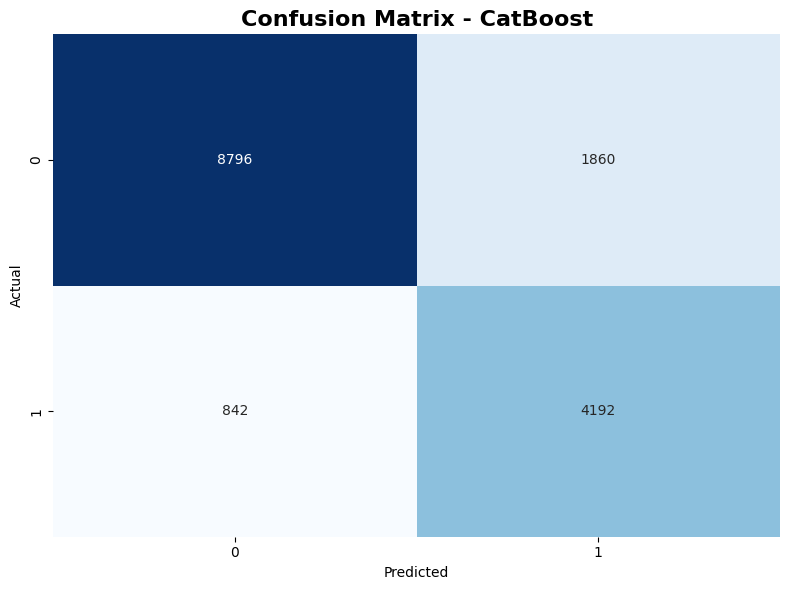

In [ ]:

model_cd_clust = catboost_train_model(Xtr_feat, val_df_clust, test_df_clust, features_clust, params)

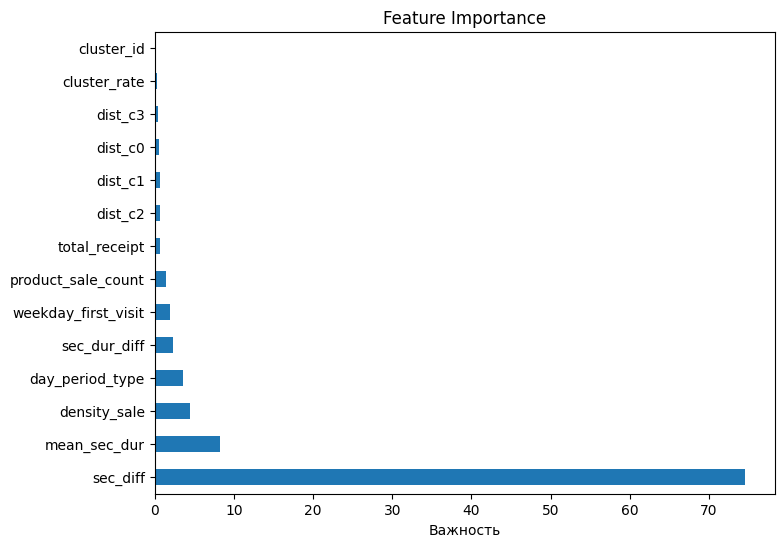

In [74]:
importances = pd.Series(model_cd_clust.feature_importances_, index=features_clust)
importances.nlargest(15).plot(kind='barh', figsize=(8, 6))
plt.title('Feature Importance')
plt.xlabel('Важность')
plt.show()

[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Info] Number of positive: 26400, number of negative: 46816
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 73216.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 73216, number of used features: 14
[LightGBM] [Warning] num_leaves is set=31, max_leaves=40 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] early_stopping_rou

f:\Машинное обучение с ментором\Проект 1\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


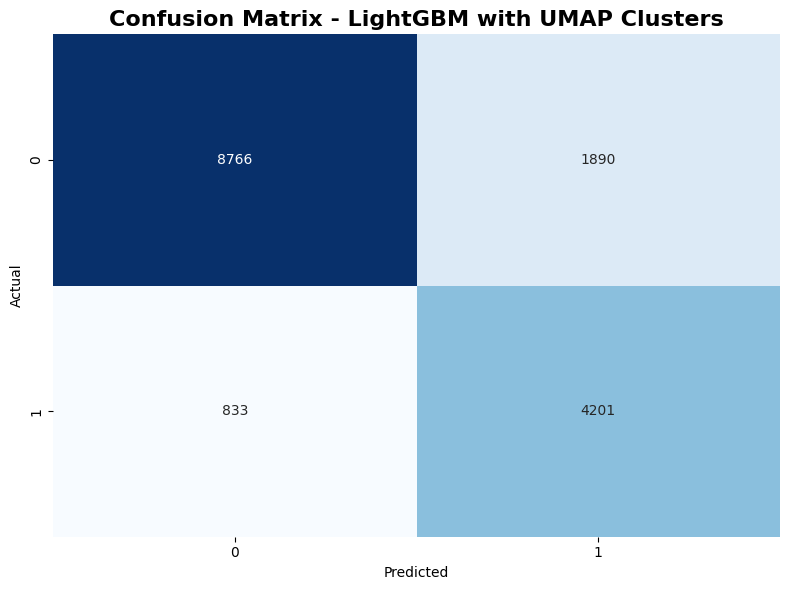

C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_counts.index, y=feature_counts.values, palette="viridis", ax=axes[0])
C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')


{'Accuracy': 0.8264499681325685, 'Precision': 0.6897061237891972, 'Recall': 0.8345252284465634, 'F1-Score': 0.7552359550561798, 'ROC-AUC': 0.8285801817908492}


C:\Users\Armen\AppData\Local\Temp\ipykernel_63640\1943011296.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gain_means.values, y=gain_means.index, palette='mako')


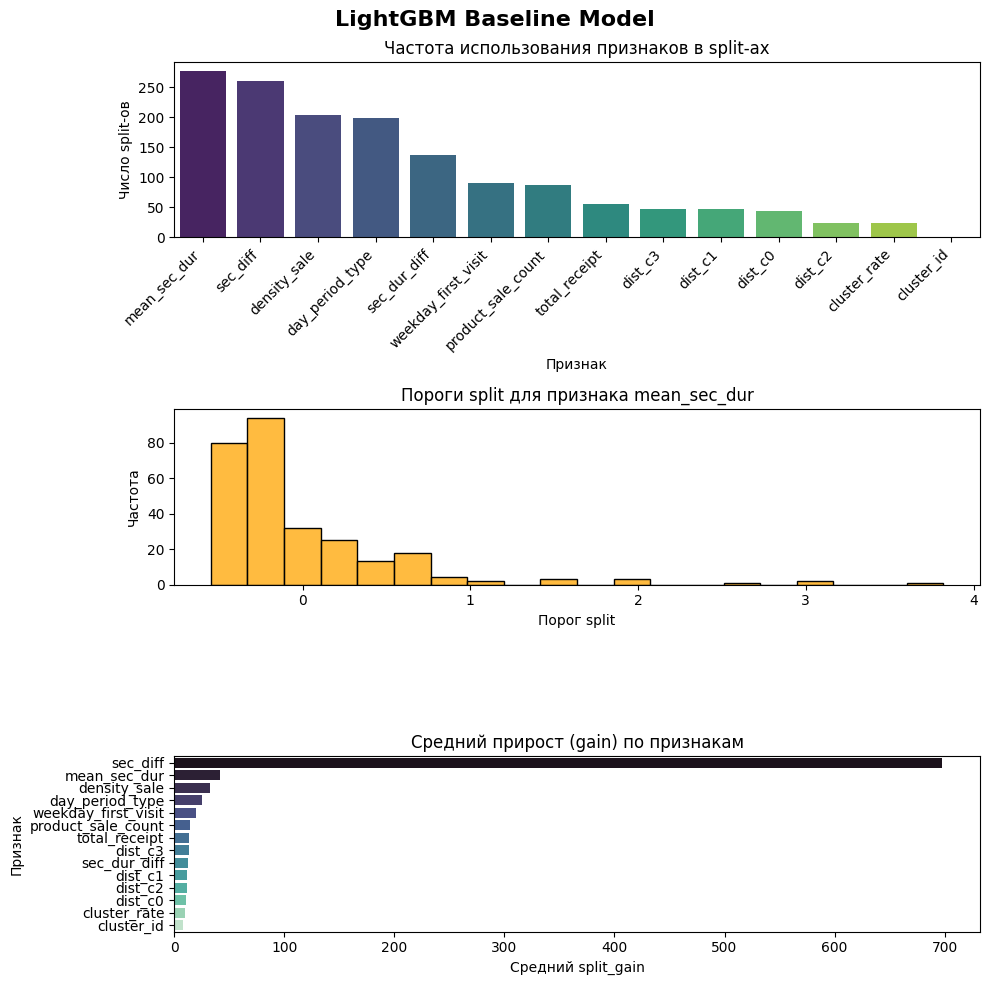

In [78]:
features = session_agg.columns
model_lgbm_cluster = lightgbm_train_model(Xtr_feat, val_df_clust, test_df_clust, features_clust, params_lgbm)
tree_df = model_lgbm_cluster.booster_.trees_to_dataframe()
visualize_tree_splits(tree_df, title='LightGBM Baseline Model')